# Tutorial 1: LIM modelling class

Code developed by Jaime Renedo Anglada (renedo.jaime@gmail.com) and Borja Marazuela.

This notebook presents an example of the usage of the class developed for the study of single-sided linear induction motors.  

This notebook should be used to learn how to use the class but not as a "design tool". 

In this tutorial the machine is created from a script where the variables are defined. Other tutorials show how to create a machine from a .json file and how to load a machine that has been already solved.

The class is defined in the file LIM_class_def.py

## Libraries needed and constants:

In [1]:
import math
import cmath
import numpy as np

import matplotlib.pyplot as plt

from LIM_class_def import SLIM_machine # class for the study of the LIMs

## Constants: 
j = complex(0,1)
pi = math.pi # define pi

## Define the geometry

# complex variable for the equations:
mu_0 = 4*pi*10.0**-7 # vacuum permeability

## Geometry definition

In [2]:
## Define the geometry

# Parameters of the motor yoke:
P = 20 # pairs of poles of the machine (integer)
m = 3 # nubmer of phases (integer)
q = 4 # slots per phase per pole (integer)
n_slot = 2*P*m*q # total number of slots of the machine (integer)
y_Q = n_slot/(2*P) # pole pitch in number of slot pitches

# for Hyperloop:
vpod_kmhr = 1000.0 # [km/hr] pod mechanical speed
vpod = vpod_kmhr/3.6 # [km/hr] pod mechanical speed
s_nom = 0.05 # nominal slip

vs = vpod/(1-s_nom) # [m/s] at 50 Hz
omega = 2*pi*400.0 # [rad/s] frequency
tau_p=pi*vs/omega # [m] pole-pitch

# slot parameters:
tau_d=tau_p/y_Q; # [m] slot-pitch
b_n = 0.7*tau_d; # [m] slot opening
h_cu = 40.0/1000.0; # [m] slot depth
b_k = tau_d-b_n; # [m] tooth-width

# entry/ exit chamfer parameters:
b_e = 200.0/1000; # [m] axial length of the chamfer
b_0 = b_k/2; # [m] axial length of the flat surface after the slots

# Air-gap parameters:
epsilon = 15.0/1000; # [m] thickness of the rail
delta = 15.0/1000; # [m] clearance gap (mechanical)
g=delta+epsilon; # [m] magnetic gap

# Yoek heights and surrounding:
h_1 = 30.0/1000; # [m] height of the chamfer
h_2 = 30.0/1000; # [m] height of the yoke
h_3 = 7.5; # [m] height of the air

w_yoke = 200.0/1000; # [m] yoke transversal length (z in my case)
h_yoke = h_2 # [m] yoke vertical height
w_rail = 300.0/1000; # [m] rail transversal length (z in my case)

# number of turns and rated current
N_k=12; # number of turns (integer)
I_max_peak=500.0; # [A] current in conductor k
slot_fill = 0.75;

J_amm2 = N_k*I_max_peak/(b_n*h_cu*1000*1000*slot_fill) # [A/mm^2] peak current density


## SLIM class usage

Definition of a new machine with the given parameters: 

In [3]:
# define the machine using the class:
Machine_A = SLIM_machine() # Create the object
Machine_A.fill_machine(P, m, q, tau_p, b_n, b_k, h_cu, b_e, b_0, epsilon, delta, h_1, h_2, h_3, w_yoke, h_yoke, w_rail, N_k, I_max_peak, slot_fill) # fill with the properties

Machine_A.export_SLIM_basic_properties() # save the properties in a .json file that can be used to create the same machine later

# The name of the machine is given by defect with the time and user name, we can change it like this:
Machine_A.name = 'tutorial_machine_1' # this will be the name of the folder created with the data files

Calculate the permeance function for N_point points along the axis:

In [4]:
# Permeance function calculation:
print('Permeance Calculation')
N_points=50000 # (integer)
Machine_A.permeance_calculation(N_points) # calculate the permeance function for N_points


Permeance Calculation


Calculate the harmonics using the Fast Fourier Transform algorithm (FFT):

In [5]:
# Calculate the harmonic spectrum using FFT:
print('Harmonics Calculation')
Machine_A.calc_harmonics_FFT() # has to be executed after the permeance calculations


Harmonics Calculation


Plot the magnetic field distribution for a given current (no induced currents): 

In [6]:
# Plot the magnetic field at a given time:
temp_mat = Machine_A.plot_field_static(I_max_peak/1.0)

Plot the harmonics:

In [7]:
# Plot the harmonics:
temp_mat = Machine_A.plot_harmonics(I_max_peak/1.0, 23)

Define the material properties: 

In [8]:
# Define the material properties for the thrust calculation:
# for an aluminium rail:
rho_c = 28.85*10**-9; # aluminium resistivity [Ohm*m]
sigma_rail = 1.0/rho_c; # electrical conductivity [1/Ohm*m]

# iron yoke properties:
mu_yoke = 500
# sigma_yoke = 6.7*10.0**6 #[S/m] conductivity (up to 10*10^6 S/m)
sigma_yoke = 1.0 # [S/m] conductivity (up to 10*10^6 S/m)

# Conductivity of the windings:
# rho_cu = 1.68*10.0**-8 # copper resistivity [Ohm*m]
rho_cu = 2.0554*10.0**-8 # copper resistivity [Ohm*m] at 70 degrees
sigma_coil = 1.0/rho_cu

print('Define materials')
Machine_A.define_materials(sigma_rail, mu_yoke, sigma_yoke, sigma_coil) # saves the values into internal properties of the class (overwrites default)

Define materials


Thrust calculation: 

In [9]:
# Calculate the thrust-slip characteristics and all other performance parameters:

# Electrical frequencies we are interested in:
f_vec1 = np.array([5.0, 10.0, 25.0, 50.0, 75.0])
f_vec2 = np.array([100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0])

f_vec_elec = np.concatenate((f_vec1, f_vec2))

# slip vector:
N_slip = 15
n_scale = 100

v_slip_1 = (np.geomspace(1, n_scale+1, num=N_slip)-1)/n_scale # to have more points around slip = 0, and few at high slips
v_slip_1[-1] = 0.99
v_slip_2 = -1.0*np.flip(v_slip_1[1:])
vec_slip = np.concatenate((v_slip_2, v_slip_1))

# Maximum number of Fourier coefficients:
N_coeffs_max = round(23/(2*tau_p/(2*(P*2*tau_p*10)))) # we could have a default value

# Percentage of main harmonic to have a threshold:
percentage_threshold = 5 # in percentage, we could have a default value

# 3D end effects on or off:
var_3D_effects = 1 # turn on (1) or off (0) the 3D effects
# we could have that it is on by default but if you put 0 then it is off...

print('Thrust Calculation')
Machine_A.calc_thrust(f_vec_elec, vec_slip, N_coeffs_max, percentage_threshold, var_3D_effects) # performance of a SLIM, has to be executed after harmonics FFT


Thrust Calculation


Generate the report and save the data in a .json file. The data is saved in a folder created with the same name as the machine (which by default it has the date and the user name).

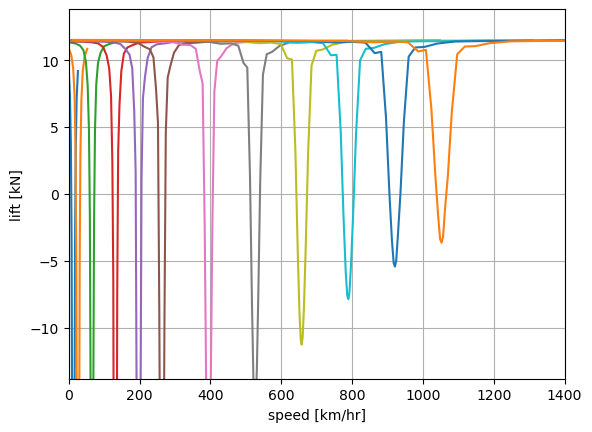

In [10]:
Machine_A.export_full_machine() # generates a json file in the folder called "full_machine.json"

#Machine_A.generate_report() # generates a report for the user in excel called "SLIM_report.xlsx"


Post-processing: 

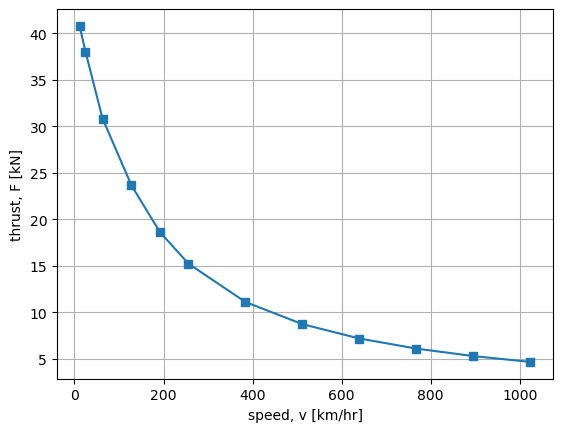

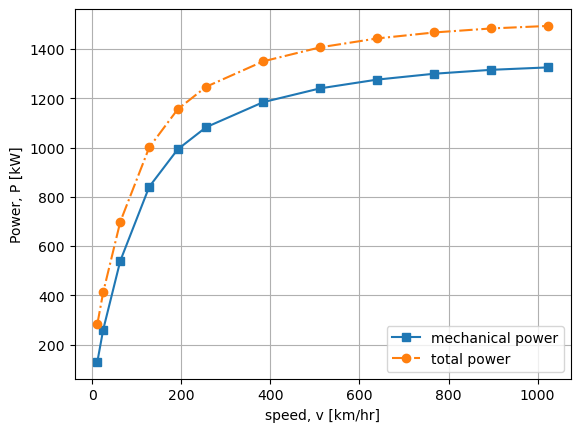

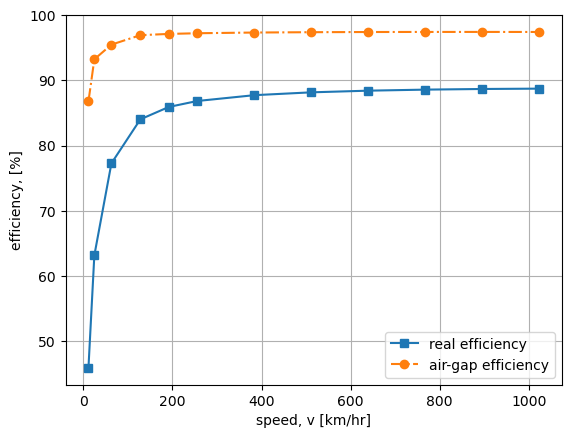

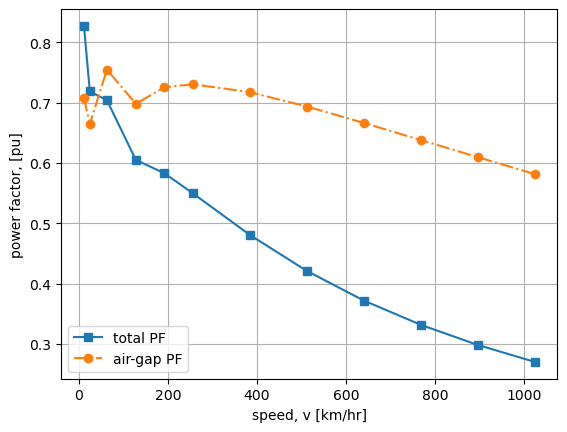

In [11]:
# To get the results:

# Maximum thrust as a function of speed:
v_max = Machine_A.v_max
thrust_max = Machine_A.thrust_max

# active power:
P_tot_max = Machine_A.P_tot_max

# efficiency:
eff_max = Machine_A.eff_max
eff_gap_max = Machine_A.eff_gap_max

# Power factor:
PF_max = Machine_A.PF_max
PF_gap_max = Machine_A.PF_gap_max

# Also the matrices with the more detailed information:
vec_slip = Machine_A.vec_slip # vector of slips
v_mat = Machine_A.v_mat # matrix of speeds
thrust_mat = Machine_A.thrust_mat # matrix of thrust
Fy_mat = Machine_A.Fy_mat # matrix of thrust

# Plot the results:

# maximum thrust
plt.plot(v_max*3.6,thrust_max/1000,'s-')

plt.ylabel("thrust, F [kN]")
plt.xlabel("speed, v [km/hr]")
plt.grid()

plt.savefig('max_thrust.png', dpi=300)
plt.show()

# maximum power:
plt.plot(v_max*3.6,np.multiply(thrust_max,v_max/1000),'s-')
plt.plot(v_max*3.6,P_tot_max/1000,'o-.')

plt.ylabel("Power, P [kW]")
plt.xlabel("speed, v [km/hr]")
plt.grid()

plt.legend(('mechanical power', 'total power'), loc='lower right')

plt.savefig('max_power.png', dpi=300)
plt.show()

# Efficiency:

plt.plot(v_max*3.6,eff_max*100,'s-')
plt.plot(v_max*3.6,eff_gap_max*100,'o-.')

plt.ylabel("efficiency, [%]")
plt.xlabel("speed, v [km/hr]")
plt.grid()
plt.legend(('real efficiency', 'air-gap efficiency'), loc='lower right')

plt.savefig('max_efficiency.png', dpi=300)
plt.show()

# Power factor:

plt.plot(v_max*3.6,PF_max,'s-')
plt.plot(v_max*3.6,PF_gap_max,'o-.')

plt.ylabel("power factor, [pu]")
plt.xlabel("speed, v [km/hr]")
plt.grid()
plt.legend(('total PF', 'air-gap PF'), loc='lower left')

plt.savefig('max_PF.png', dpi=300)
plt.show()

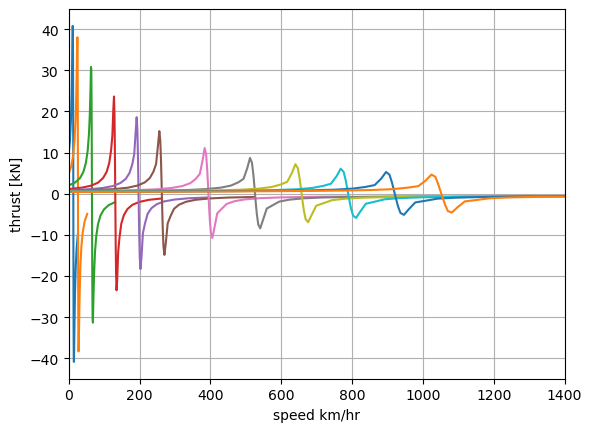

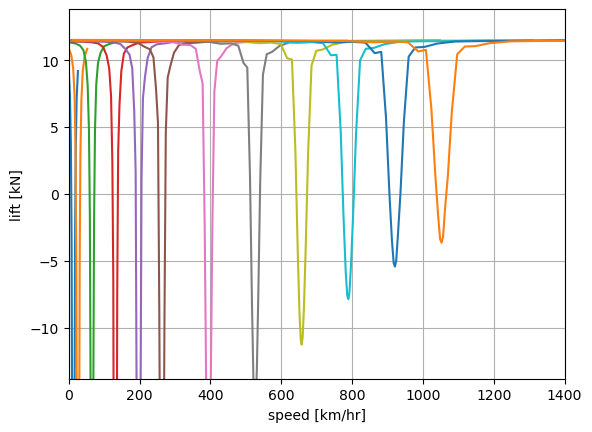

In [12]:

# Machine A: 
thrust_mat_1 = Machine_A.thrust_mat
Fy_mat_1 = Machine_A.Fy_mat
v_mat_1 = Machine_A.v_mat

# Thrust speed characteristic
n_elements = len(f_vec_elec)
vmax_plot = 1400

for k in range(n_elements):
    plt.plot(3.6*v_mat_1[k,:], np.transpose(thrust_mat_1[k,:])/1000,'-')

plt.xlabel("speed km/hr")
plt.ylabel("thrust [kN]")
plt.xlim(0, vmax_plot)
plt.grid()
plt.savefig('comparison_thrust_speed.png', dpi=300)

plt.show()

max_lift = np.amax(Fy_mat_1[k,:])/1000

for k in range(n_elements):
    plt.plot(3.6*v_mat_1[k,:], np.transpose(Fy_mat_1[k,:])/1000,'-')

plt.xlabel("speed [km/hr]")
plt.ylabel("lift [kN]")
plt.grid()
plt.ylim(-1.2*max_lift, 1.2*max_lift)
plt.xlim(0, vmax_plot)
plt.savefig('comparison_lift_speed.png', dpi=300)

plt.show()

